### Tutorials on Data Analysis using Python

### 2. Statistical Analysis:

In [203]:
# First install scipy package (using Anaconda): Anaconda>>Environments>>All>>Search for Scipy, click to install it
# Or pip install scipy --upgrade
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12}) # Increase fontsize
import scipy.stats as stats
from statsmodels.stats.multicomp import MultiComparison

In [211]:
df_movie = pd.read_csv("moviedata.csv")
rowcount = len(df_movie.index)
df_movie.dropna(inplace=True)
print('The number of rows before and after removing observations with missing data is {} and {}, respectively'.format(rowcount,len(df_movie.index)))

The number of rows before and after removing observations with missing data is 231 and 187, respectively


In [219]:
# Create a new column profit in df_movie by subtracting the variables gross and budget
df_movie['profit'] = (df_movie.gross - df_movie.budget).round(2)
df_movie['sequelcat'] = np.where(df_movie.sequel == 1, 'original', 'sequel')

save1 = df_movie.loc[df_movie.sequelcat == 'original'].filter(['movie', 'profit'], axis = 1)
display(save1.sort_values(by='profit', ascending=False).head(5).style.hide(axis = 'index').format(precision=0).set_caption('The five most profitable original movies'))

save2 = df_movie.loc[df_movie.sequelcat == 'sequel'].filter(['movie', 'profit'], axis = 1)
display(save2.sort_values(by='profit', ascending=True).head(5).style.hide(axis = 'index').format(precision=0).set_caption('The five least profitable movie sequels', ))

movie,profit
American Sniper,291200000
The Lego Movie,198000000
Inside Out,170000000
Guardians of the Galaxy,163000000
Neighbors,132000000


movie,profit
Terminator Genisys,-65600000
Sin City: A Dame to Kill For,-51200000
The Expendables 3,-50700000
Night at the Museum: Secret of the Tomb,-13000000
Jack Ryan: Shadow Recruit,-9500000


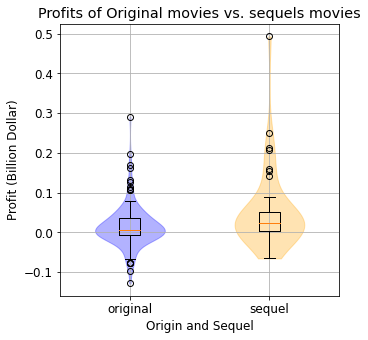

In [221]:
plotlabels = ['original','sequel']
plotdata = [df_movie[df_movie['sequelcat']==label]['profit'] / 1000000000 for label in plotlabels]
colors = ['blue','orange']
plt.figure(figsize=(5, 5))
vparts = plt.violinplot(plotdata, showextrema=False) # Violin plot incl. density estimation
# We use zip to return a single iterator object, having mapped values from all the containers. 
for patch, color in zip(vparts['bodies'], colors):
    patch.set_color(color) # Set color for violin plot
plt.boxplot(plotdata, widths=0.15, zorder=3, labels=plotlabels) # Overlay box plot
plt.xlabel('Origin and Sequel')
plt.ylabel('Profit (Billion Dollar)')
plt.title('Profits of Original movies vs. sequels movies')
plt.grid(zorder=0) # Add grid
plt.show()

In [226]:
# Use windsorize function with 5% (0.05) limits on both ends
# Winsorize provides an unbiased representation of the distribution of the variable.
# scipy.stats.mstats.winsorize (a, limits=None, inclusive= (True, True), inplace=False, axis=None)
# Returns a Winsorized version of the input array. The (limits)th lowest values are set to the (limits)th percentile, 
# and the (limits)th highest values are set to the (limits)th percentile
# Another standard method to deal with outliers is winsorize (transformatin technique to moderate the influence of the extreme 
# values) While trimming is simply removing outlier from dataset, winsorising changes the outlier to the nearest inlier.
# Without droping a single row (all features), i.e., instead of trimming, we can use winsorizing
df_movie['likes_winsor'] = stats.mstats.winsorize(df_movie['likes'], limits=[0.05, 0.05])

print('The minimum and maximum values for the original likes is {:.0f} and {:.0f}, respectively.'.format(np.min(df_movie['likes']), np.max(df_movie['likes'])))
print('The minimum and maximum values for the winsorised likes is {:.0f} and {:.0f}, respectively.'.format(np.min(df_movie['likes_winsor']), np.max(df_movie['likes_winsor'])))

# To create ratings bins based on the defined ranges (default is right=false so no need to include)
df_movie['ratingscat'] = pd.cut(df_movie['ratings'], bins=[0,5.99,6.79,10], labels=['Negative', 'Neutral', 'Positive'])

ratings_labels = ['negative', 'neutral', 'positive']
ratings_values = [0,5.9,6.7,10]
df_movie['ratingscat'] = pd.cut(df_movie['ratings'], bins=ratings_values, labels=ratings_labels).astype('category')

# Show value counts for new ratingscat category

print() #space
print("Summary of value counts for the new ratings category")
df_movie["ratingscat"].value_counts()

The minimum and maximum values for the original likes is 1 and 370552, respectively.
The minimum and maximum values for the winsorised likes is 85 and 38810, respectively.

Summary of value counts for the new ratings category


neutral     68
positive    68
negative    51
Name: ratingscat, dtype: int64

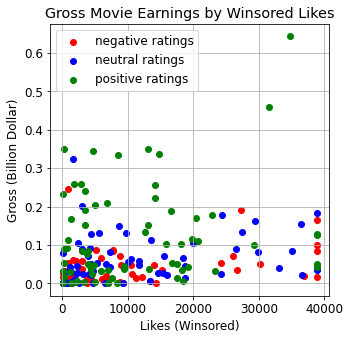

In [230]:
# Create scatter plot
plotlabels = np.sort(df_movie['ratingscat'].unique())
plotdata = [df_movie[df_movie['ratingscat']==label][['likes_winsor','gross']] for label in plotlabels]
colors = ['red','blue','green'] # Get colors
plt.figure(figsize=(5, 5)) # Specify figure size
for i, data in enumerate(plotdata):
    plt.scatter(data['likes_winsor'],data['gross'] / 1000000000,color=colors[i],label=f"{plotlabels[i]} ratings")
plt.xlabel('Likes (Winsored)')
plt.ylabel('Gross (Billion Dollar)')
plt.title('Gross Movie Earnings by Winsored Likes')
plt.legend()
plt.grid(zorder=0)
plt.ticklabel_format(axis='y', style='plain')
plt.show()

In [233]:
df_movie_stats = df_movie.groupby(['ratingscat', 'sequelcat'])[['profit', 'gross', 'budget']].agg({'profit': ['mean', 'std'], 'gross': ['mean', 'std'], 'budget': ['mean', 'std']}).astype('int64')

# To add a column that counts the values for each group:
df_movie_stats.insert(0, "N", df_movie['profit'].groupby([df_movie['ratingscat'], df_movie['sequelcat']]).count(), True)

# Print to screen
df_movie_stats

N    profit                 gross             \
                              mean        std       mean        std   
ratingscat sequelcat                                                  
negative   original   41   -272956   46907790   39060335   42021960   
           sequel     10  22003000   19465550   60253000   71073044   
neutral    original   50   8570419   40523417   46181074   50940229   
           sequel     18  34738888   72196383   98116666   72482608   
positive   original   54  33555944   61828501   83507796   88925279   
           sequel     14  98314285  140955414  266528571  143007167   

                         budget            
                           mean       std  
ratingscat sequelcat                       
negative   original    39333292  42816922  
           sequel      38250000  62365076  
neutral    original    37610655  41910730  
           sequel      63377777  34388499  
positive   original    49951851  52966517  
           sequel     168214285  50710609

In [247]:
# Recall) Bartlett's test works well for data that is normally distributed or even if the sample distribution is 
# Chi-squared (like normal distribution; shifted to left-side)
# We can compare more than two groups (here, we have three groups of proft), we want to check the p value, to see wether those 
# variances are homogeneous or not
# The assumption is that the variances are homogeneous; # p-value is that chance of the likelihood of the difference
# in chance is very small
# If the p-values are too small (<0.05), the tests (bartlett or levene) indicate that the variances are not homogeneous
# Bartlett's test (chi-sq and p-value) is similar to Levene's test (W and p-value), but they just use different values
# In Levene, W-value is equal to the F-statistic which is produced by ANOVA test (analysis of variance)
# Both tests can indicate that the variances are not homogeneous. We can run a Welch test when comparing the means.
# In the t-test, we assume that non-homogeneous variances
stat, p = stats.bartlett(df_movie[df_movie['ratingscat']=='negative']['profit'], df_movie[df_movie['ratingscat']=='neutral']['profit'], df_movie[df_movie['ratingscat']=='positive']['profit'])
print(f"test statistic chi_sq = {stat:.4f}; p-value = {p:.4e}")

test statistic chi_sq = 32.2842; p-value = 9.7628e-08


The null hypothesis (H0 assumption) is that all three categorise have equal variances. (i.e., Their variances are homogeneous)
$H_0: \sigma_{profit,Negative}^2 = \sigma_{profit,Neutral}^2 = \sigma_{profit,Positive}^2$

The resulting p-value is less than 0.05, so the assumption H0 is rejected, and thus the variances in profit are not homogeneous. Conceptually, the test statistically confirms the difference between the variances of the profit of three rating groups (positive, negative, neutral) is statistically significant.

In [248]:
# One-way analysis of variance (ANOVA) test is for more than two groups
# ANOVA (F-test) a parametric test to determine whether a categorical variable (with k groups) has a
# significance influence on the variance of a variable
# To compare multiple comparisons, while t-test could only compare 2 groups
# We use f_oneway from scipy for the F-value. The null hypothesis (H0) is that there are no differences in the population 
# between the means of the individual groups. Alternative hypothesis (H1) is that in the populationat least two group means
# differ from each other.
# The F-statistic value shows how far the data is scattered from the mean, larger F-value indicate a larger dispersion of data.
# The F‐statistic equals to the variance between groups divided by the variance within groups
# If the variance between groups is so much greater than the variance within groups (e.g., algorithms), 
# there is a significant relationship # between the two variables
# Then we need to know which one is significantly different: Thus, we use PostHoc comparisons to gain this information
# The difference between the posthoc analysis tests is most likely due to the non-homogeneous variances
stat, p = stats.f_oneway(df_movie[df_movie['ratingscat']=='negative']['profit'], df_movie[df_movie['ratingscat']=='neutral']['profit'], df_movie[df_movie['ratingscat']=='positive']['profit'])
print("The F-value = {:.4f} and p-value = {:.4e}".format(stat, p))

The F-value = 7.1544 and p-value = 1.0181e-03


In [249]:
# Make sure statsmodel is installed: Anaconda >> Environment >> search for statsmodels and install it
# To know which of the three groups is significantly different than others
# Mmultiple PostHoc analysis tests (Pairwise t-Test, Tukey honestly significant difference"), that are very similar, 
# they just use different values
# Tukey HSD test compares the means of every group
comp = MultiComparison(df_movie['profit'], df_movie['ratingscat']).tukeyhsd().summary()
print("Tukey HSD")
print("----------")
print("")
print(comp)

Tukey HSD
----------

           Multiple Comparison of Means - Tukey HSD, FWER=0.05            
 group1   group2     meandiff   p-adj      lower          upper     reject
--------------------------------------------------------------------------
negative  neutral 11402489.0697 0.6127 -17114502.1072 39919480.2465  False
negative positive 42793666.2745 0.0014  14276675.0976 71310657.4514   True
 neutral positive 31391177.2049 0.0151   4989573.5883 57792780.8214   True
--------------------------------------------------------------------------


According to adjusted p-values (p-adj) of pairwise analysis result, there is significant differences in the mean profit of negative - positive (0.0014<0.05) and neutral - positive (0.0151<0.05) rated movies. However, the p-adj of negative - neutral (0.6127>0.05) of rated movies indicates that there is a similarity between the mean profits of the groups, and we cannot reject the null hypothesis.

In [253]:
# First find the means for the profits for original and sequel movies

mean_original = np.mean(df_movie[df_movie['sequelcat']=='original']['profit'])
mean_sequel = np.mean(df_movie[df_movie['sequelcat']=='sequel']['profit'])

print("The mean profit for original movies is ${:.0f}, and for sequels is ${:.0f}".format(mean_original, mean_sequel))
print("")

# Recall) When variance between two groups is not homogeneous, we use Welch t-test
# To analyse the difference of means with the assumption that each of the groups there have a difference variances (unpaired or
# independant t-test)
# Recall) Levene’s Test – A test that is more robust to deviations from normal distribution than Bartlett's test.
# Levene's test is less sensitive than the Bartlett's test 
# If data is normally distributed, then Bartlett's test is better

# Then conduct Barlet and Levene tests to determine if a Welch test is required (for non-homogeneous variances)
# Bartlett test
stat, p = stats.bartlett(df_movie[df_movie['sequelcat']=='original']['profit'], df_movie[df_movie['sequelcat']=='sequel']['profit'])
print("BARTLETT TEST: test statistic chi_sq = {:.4f}; p-value = {:.4e}".format(stat, p))

# Levene test
stat, p = stats.levene(df_movie[df_movie['sequelcat']=='original']['profit'], df_movie[df_movie['sequelcat']=='sequel']['profit'])
print("LEVENE TEST:   test statistic      W = {:.4f};  p-value = {:.4e}".format(stat, p))

print("")
print("Both tests indicate the variances are non-homogeneous so we t-test with Welch method")
print("")

# Recall) t-test is for two-group comparison 
# Recall) statistic package stats.ttest_ind in python; T-test independent for the unpaired, 
# this is not for homogeneous variances
# T-test is use to compare only two groups, no more than that
# equal_var = true means you are working on homogeneous variances
# From this, we can get t-test result (t value) the diff between two means in units of standard error
# p-value: how likely it is that the sample means are different by chance, based on comparing t-value with the critical t-values
# Since p-value is very small, so it is very unlikely that the difference in ... between ... and ...is just by chance

# >>> t-test independent function, equal_var = False. And we know that t-test measures the differences between two means
# in units of standard error, and p-value shows how likely it is that the sample means differ by chance. This is based on 
# comparing the t-value with critical t-values.
# default value for equal_var is True.

# t-value is a test statistic that measures the differences between two means in units of standard error
# significance value is 5%, 0.05, and p-value is absolutely smaller than significance value, so we need to reject
# the null hypothesis (null hypothesis is that these two groups have no difference)

# Conduct a t-test where 'equal_var=False'
# For variance homogenous, we use equal_var=True, but for the Welch test we use equal_var=True, if it is set to true, then the
# assumption is that the variance is the same
# The following is the independent sample t-test
stat, p = stats.ttest_ind(a=df_movie[df_movie['sequelcat']=='sequel']['profit'], b=df_movie[df_movie['sequelcat']=='original']['profit'], equal_var=False)
print("T-TEST WITH WELCH MOD: test statistic t = {:.4f}; p-value = {:.6f}".format(stat, p))

The mean profit for original movies is $15374833, and for sequels is $52898333

BARTLETT TEST: test statistic chi_sq = 29.2724; p-value = 6.2886e-08
LEVENE TEST:   test statistic      W = 5.0740;  p-value = 2.5462e-02

Both tests indicate the variances are non-homogeneous so we t-test with Welch method

T-TEST WITH WELCH MOD: test statistic t = 2.3808; p-value = 0.021287


The null hypothesis (H0) is that all groups have equal variance:

$H_0: \sigma_{profit,Original}^2 = \sigma_{profit,Sequel}^2$

A Levene's test is used to measure variance equality as it is more robust to deviations from the normal distribution. The results of the Levene's test for variance shows <em>p < .05</em>. We therefore reject the null hypothesis and conclude that the population variances are not equal.

Since both Barlett and Levene's test indicated the variances are not homogeneous, we ran a Welch test (t-test with non-homogeneous variances) to determine if the mean profit of original and sequel movies are equal. The t-Test confirms there are differences in the mean profit of original movies compared to movie sequels (<em>p = .0213</em>). 

Given we are performing only a single comparison the Pairwise t-Test is an appropriate post-hoc test. The Pairwise t-Test confirms that the mean profit of original movies is significantly less than the mean profit of movie sequels (<em>t = -3.2646, p = .0013</em>). We conclude that the means of the profots for original and sequel movies is statistically significant.